In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import joblib
import shap

In [84]:
df_data = pd.read_excel("data/synthetic_ltd_claims_soa_expanded.xlsx")

In [85]:
df_data 

,policy_id,age,gender,state,industry,occupation_class,salary_band,elimination_period_days,benefit_pct,coverage_type,...,ssdi_offset_indicator,hours_worked_per_week,employment_status,exposure_year,coverage_start_year,claim_incident,incurred_year,claim_duration_months,recovery_status,return_to_work_flag
0,1,58,M,MA,Healthcare,4,60-80k,90,0.6,EmployerPaid,...,0,40,FullTime,2019,2018,0,NaN,0,NaN,0
1,2,48,F,RI,Services,1,40-60k,30,0.6,EmployerPaid,...,0,40,FullTime,2020,2018,0,NaN,0,NaN,0
2,3,34,F,NY,Services,3,40-60k,90,0.6,EmployerPaid,...,0,40,FullTime,2019,2011,0,NaN,0,NaN,0
3,4,62,F,NJ,Education,2,80-120k,90,0.7,EmployerPaid,...,0,35,FullTime,2019,2011,0,NaN,0,NaN,0
4,5,27,F,RI,Retail,3,80-120k,90,0.6,EmployerPaid,...,0,40,FullTime,2019,2017,0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,35,M,ME,Healthcare,3,60-80k,180,0.7,EmployerPaid,...,0,40,FullTime,2022,2014,0,NaN,0,NaN,0
9996,9997,64,M,VT,Manufacturing,3,>120k,90,0.6,EmployerPaid,...,0,25,PartTime,2020,2015,0,NaN,0,NaN,0
9997,9998,34,M,VT,Education,3,60-80k,90,0.6,Voluntary,...,0,35,FullTime,2019,2011,0,NaN,0,NaN,0
9998,9999,20,M,ME,Retail,1,<40k,30,0.6,EmployerPaid,...,0,40,FullTime,2022,2018,0,NaN,0,NaN,0


##### Review of Year-Based Columns (Transformation vs. Drop Decisions)

exposure_year
→ Indicates the calendar period the life is exposed. Useful for creating a new COVID-era feature. Keep for transformation, not as a raw predictor.

coverage_start_year
→ Represents when coverage began. Effectively duplicates years_with_employer. Adds no new signal → can be dropped.

incurred_year
→ Only populated for claims (incident = 1). Not available at prediction time for non-claim lives → must be dropped for modeling.

In [86]:
df_data['is_covid_period'] = (df_data['exposure_year'] >= 2020).astype(int)

In [87]:
df_data_cat_cols = ['gender', 'state', 'industry', 'benefit_duration',
       'salary_band','coverage_type','integration_type','ssdi_offset_indicator','employment_status','employment_status','is_covid_period']

df_data_cont_cols = ['age','occupation_class','elimination_period_days','benefit_pct','years_with_employer','max_monthly_benefit','hours_worked_per_week']


#### - Model building

"recovery_status", "claim_duration_months", "return_to_work_flag" → These fields describe outcomes after a claim, so they are not valid predictors. Dropping them.

In [88]:
X = df_data.drop(columns=['policy_id','claim_incident','incurred_year','coverage_start_year','exposure_year','return_to_work_flag','claim_duration_months','recovery_status'])
y = df_data['claim_incident']

In [133]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [134]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop=None, sparse_output=False,handle_unknown="ignore"), df_data_cat_cols),
        ("num", "passthrough", df_data_cont_cols)
    ]
)

In [135]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
scale_pos_weight

125.98412698412699

In [136]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.0005,
    subsample=0.6,
    colsample_bytree=0.6,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", model)
    ]
)


In [137]:
param_grid = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [3, 4, 5],
    "model__learning_rate": [0.1, 0.05, 0.02],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    # optional: try a couple of scale_pos_weight values if you want
    # "model__scale_pos_weight": [scale_pos_weight, scale_pos_weight * 0.5, scale_pos_weight * 1.5],
}


In [138]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring="roc_auc",      
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200, model__subsample=0.8; total time=   0.9s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200, model__subsample=0.8; total time=   0.9s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200, model__subsample=0.8; total time=   0.9s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200, model__subsample=0.8; total time=   1.0s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200, model__subsample=0.8; total time=   1.0s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200, model__subsample=0.6; total time=   1.0s
[CV] END model__colsample_bytree=0.6

/Users/apare/.pyenv/versions/3.10.14/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['gender',
                                                                          'state',
                                                                          'industry',
                                                                          'benefit_duration',
                                                                          'salary_band',
                                                                          'coverage_type',
                                                                          'integration_type',
                                                                          'ssdi_offset_indicator',
                                                                          'employment_status...
                                                      monotone_constraints=None,
                                                      n_estimators=300,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42,
                                                      reg_alpha=None,
                                                      reg_lambda=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.6, 0.8, 1.0],
                         'model__learning_rate': [0.1, 0.05, 0.02],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [200, 400, 600],
                         'model__subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc', verbose=2)

#### - Evaluate the model

In [139]:
best_clf = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)

Best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.02, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 1.0}


In [140]:
y_proba = best_clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

In [141]:
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

ROC-AUC: 0.701203377016129

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86      1984
           1       0.02      0.62      0.04        16

    accuracy                           0.75      2000
   macro avg       0.51      0.69      0.45      2000
weighted avg       0.99      0.75      0.85      2000


Confusion matrix:
 [[1496  488]
 [   6   10]]


In [142]:
joblib.dump(best_clf, "model/ltd_best_model_pipeline.pkl")

['model/ltd_best_model_pipeline.pkl']

#### SHAP

In [143]:
shap.initjs()

In [144]:
best_clf

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'state',
                                                   'industry',
                                                   'benefit_duration',
                                                   'salary_band',
                                                   'coverage_type',
                                                   'integration_type',
                                                   'ssdi_offset_indicator',
                                                   'employment_status',
                                                   'employment_status',
                                                   'is_covid_period']),
                                                 ('num', 'passthrough',
                                                  ['age', 'occupation_c...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.02, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=3, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=-1, num_parallel_tree=1,
                               predictor='auto', random_state=42, reg_alpha=0,
                               reg_lambda=1, ...))])

In [145]:
preprocess = best_clf.named_steps["preprocess"]
xgb_model = best_clf.named_steps["model"]

In [146]:
# Taking small sample
X_bg = X_train.sample(500, random_state=42)
X_test_sample = X_test.sample(500, random_state=42)

In [147]:
# Transforming
X_bg_trans = preprocess.transform(X_bg)
X_test_trans = preprocess.transform(X_test_sample)

In [148]:
#getting feature names
feature_names = preprocess.get_feature_names_out()
feature_names

array(['cat__gender_F', 'cat__gender_M', 'cat__state_CT', 'cat__state_MA',
       'cat__state_ME', 'cat__state_NH', 'cat__state_NJ', 'cat__state_NY',
       'cat__state_PA', 'cat__state_RI', 'cat__state_VT',
       'cat__industry_Construction', 'cat__industry_Education',
       'cat__industry_Finance', 'cat__industry_Healthcare',
       'cat__industry_Manufacturing', 'cat__industry_PublicSector',
       'cat__industry_Retail', 'cat__industry_Services',
       'cat__industry_Technology', 'cat__benefit_duration_2Y',
       'cat__benefit_duration_5Y', 'cat__benefit_duration_To65',
       'cat__salary_band_40-60k', 'cat__salary_band_60-80k',
       'cat__salary_band_80-120k', 'cat__salary_band_<40k',
       'cat__salary_band_>120k', 'cat__coverage_type_EmployerPaid',
       'cat__coverage_type_Voluntary',
       'cat__integration_type_IntegratedSSDI',
       'cat__integration_type_Primary', 'cat__integration_type_nan',
       'cat__ssdi_offset_indicator_0', 'cat__ssdi_offset_indicator_1',


In [149]:
# Building a TreeExplainer on the XGBoost model
explainer = shap.TreeExplainer(xgb_model)

In [150]:
# We feed the model’s processed data into SHAP. 
# SHAP breaks the model prediction into a baseline plus contributions from each feature. 
# check_additivity=False tells SHAP not to enforce that the sum of contributions must perfectly reconstruct the prediction, 
# which avoids issues with XGBoost. We pass feature names so plots are human-readable.

shap_values = explainer(
    X_test_trans,
    check_additivity=False
)

In [151]:
shap_values.values

array([[-0.00868117,  0.        , -0.00056088, ...,  0.14795792,
        -0.07137585, -0.02586316],
       [ 0.00058149,  0.        , -0.00056088, ..., -0.11820774,
        -0.01430474,  0.04305689],
       [-0.04168351,  0.        , -0.00056088, ...,  0.22594595,
        -0.03570841, -0.02311424],
       ...,
       [-0.00887228,  0.        , -0.00056088, ..., -0.0810777 ,
         0.2526316 ,  0.00956777],
       [-0.01211588,  0.        , -0.00036197, ...,  0.00804161,
        -0.0432462 , -0.13325536],
       [ 0.00404446,  0.        , -0.00056088, ..., -0.14498456,
        -0.10400918,  0.00499528]], dtype=float32)

In [152]:
shap_values.base_values

array([-0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00

In [153]:
shap_values.feature_names = feature_names
print(shap_values.feature_names)

['cat__gender_F' 'cat__gender_M' 'cat__state_CT' 'cat__state_MA'
 'cat__state_ME' 'cat__state_NH' 'cat__state_NJ' 'cat__state_NY'
 'cat__state_PA' 'cat__state_RI' 'cat__state_VT'
 'cat__industry_Construction' 'cat__industry_Education'
 'cat__industry_Finance' 'cat__industry_Healthcare'
 'cat__industry_Manufacturing' 'cat__industry_PublicSector'
 'cat__industry_Retail' 'cat__industry_Services'
 'cat__industry_Technology' 'cat__benefit_duration_2Y'
 'cat__benefit_duration_5Y' 'cat__benefit_duration_To65'
 'cat__salary_band_40-60k' 'cat__salary_band_60-80k'
 'cat__salary_band_80-120k' 'cat__salary_band_<40k'
 'cat__salary_band_>120k' 'cat__coverage_type_EmployerPaid'
 'cat__coverage_type_Voluntary' 'cat__integration_type_IntegratedSSDI'
 'cat__integration_type_Primary' 'cat__integration_type_nan'
 'cat__ssdi_offset_indicator_0' 'cat__ssdi_offset_indicator_1'
 'cat__employment_status_FullTime' 'cat__employment_status_PartTime'
 'cat__employment_status_FullTime' 'cat__employment_status_Part

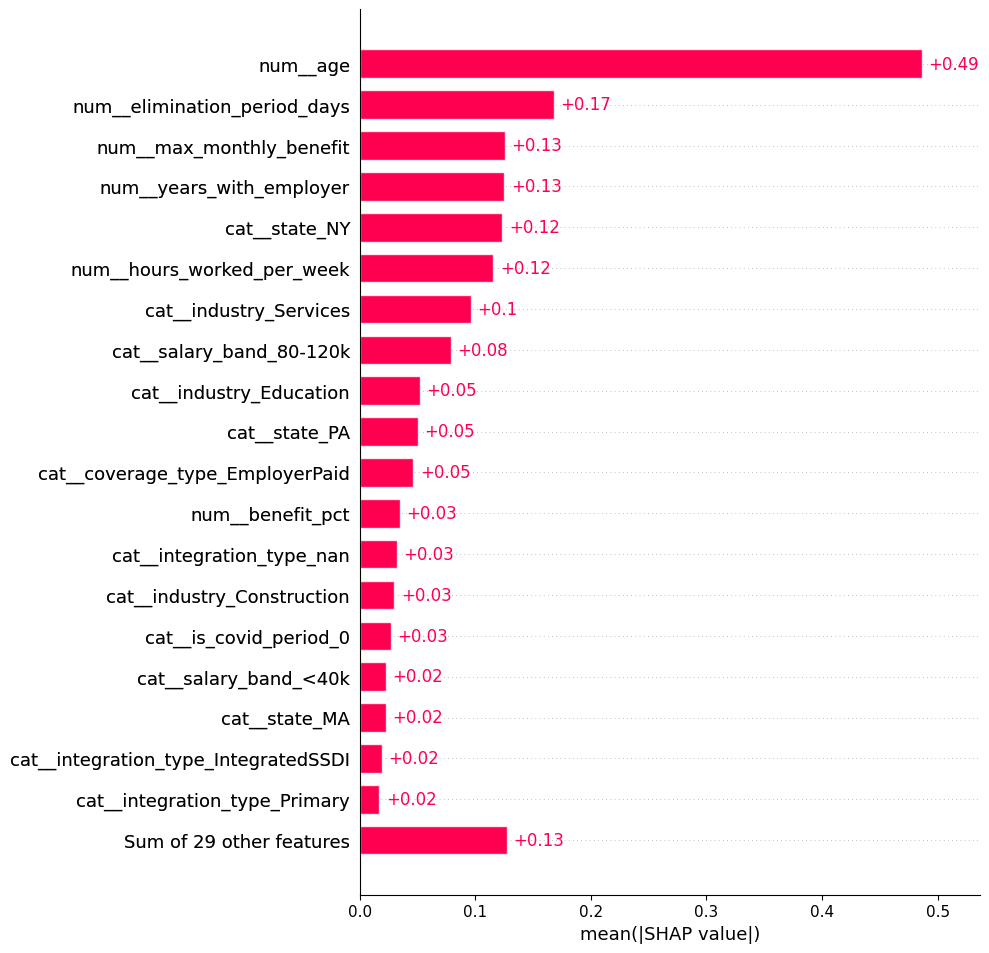

In [157]:
shap.plots.bar(shap_values, max_display=20)

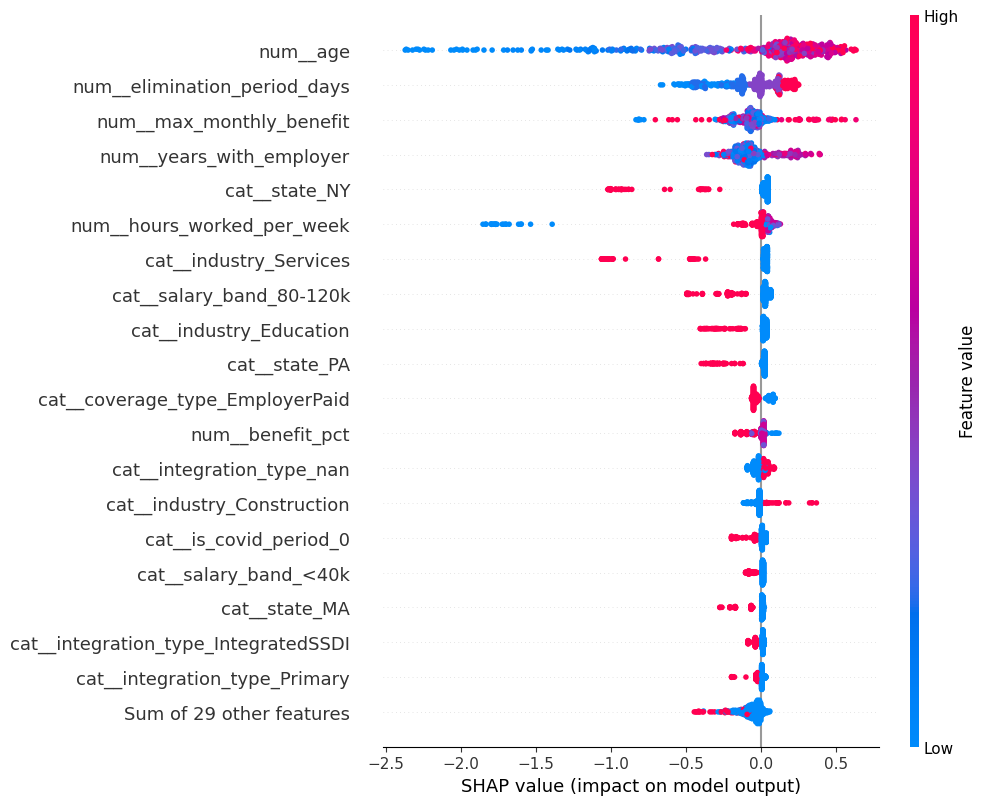

In [158]:
shap.plots.beeswarm(shap_values, max_display=20)

In [159]:
X_bg = X_train.sample(500, random_state=42)
X_bg.to_parquet("data/shap_training_sample.parquet")